# **The PLAsTiCC Astronomy "Starter Kit" Classification Demo**

### -Gautham Narayan, Renée Hložek, Emilie Ishida 20180831

***

In [1]:
# You can edit the font size here to make rendered text more comfortable to read
# It was built on a 13" retina screen with 18px
from IPython.core.display import display, HTML
display(HTML("<style>.rendered_html { font-size: 18px; }</style>"))

In this notebook, we'll look at how astronomers have approached light curve classification, and provide you some references and useful packages if you want to get a sense for what has been done in the past.

It's almost certain that some astronomers will approach PLAsTiCC with these kinds of methods, so if you want to win, you'll likely have to do something better!

The PLAsTiCC Dataset is not provided with this notebook, but rather is available directly from Kaggle. 
We'll assume that you've downloaded it and put it in the `data/` directory of this starter kit.

We'll begin by importing some packages that might be useful. 

In [2]:
%matplotlib notebook

import os
from collections import Counter, OrderedDict
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
from astropy.table import Table
import schwimmbad
from cesium.time_series import TimeSeries
import cesium.featurize as featurize
from tqdm import tnrange, tqdm_notebook
import sklearn 
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
import seaborn as sns

/Users/gnarayan/anaconda3/envs/plasticc/lib/python3.6/site-packages/sklearn/ensemble/weight_boosting.py:29: DeprecationWarning: numpy.core.umath_tests is an internal NumPy module and should not be imported. It will be removed in a future NumPy release.
  from numpy.core.umath_tests import inner1d


We described how the the data is split into a light curve table and a metadata table in the astronomy starter kit. We've described the format of these files there, so if you need a refresher, take a look there again.

We described a mapping from string passband name to integer passband IDs. Here, we'll create an `OrderedDict` to invert that transformation. 

In [3]:
pbmap = OrderedDict([(0,'u'), (1,'g'), (2,'r'), (3,'i'), (4, 'z'), (5, 'Y')])

# it also helps to have passbands associated with a color
pbcols = OrderedDict([(0,'blueviolet'), (1,'green'), (2,'red'),\
                      (3,'orange'), (4, 'black'), (5, 'brown')])

pbnames = list(pbmap.values())

Next, we'll read the metadata table.

In [4]:
datadir = 'data/'
metafilename = f'{datadir}/plasticc_training_set_metadata.csv'
metadata = Table.read(metafilename, format='csv')
nobjects = len(metadata)
metadata

object_id,ra,decl,gall,galb,ddf_bool,hostgal_specz,hostgal_photoz,hostgal_photoz_err,distmod,mwebv,target
int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64
615,349.046051,-61.943836,320.79653,-51.753706,1,0.0,0.0,0.0,nan,0.017,92
713,53.085938,-27.784405,223.525509,-54.460748,1,1.8181,1.6267,0.2552,45.4063,0.007,88
730,33.574219,-6.579593,170.455585,-61.548219,1,0.232,0.2262,0.0157,40.2561,0.021,42
745,0.189873,-45.586655,328.254458,-68.969298,1,0.3037,0.2813,1.1523,40.7951,0.007,90
1124,352.711273,-63.823658,316.922299,-51.059403,1,0.1934,0.2415,0.0176,40.4166,0.024,90
1227,35.683594,-5.379379,171.992947,-59.253501,1,0.0,0.0,0.0,nan,0.02,65
1598,347.84671,-64.760857,318.929827,-49.143596,1,0.1352,0.182,0.0304,39.7279,0.019,90
1632,348.595886,-63.07262,320.023289,-50.71306,1,0.6857,0.7014,0.01,43.1524,0.021,42
1920,149.414062,3.433834,234.919132,42.24555,1,0.3088,0.3229,0.336,41.1401,0.027,90


Since we can split between extragalactic and galactic sources on the basis of redshift, you may choose to build separate classifiers for the two sets. 

Or you might split the deep-drilling fields (DDF i.e. `ddf_bool` = 1) up from the wide-fast-deep fields (WFD i.e. `ddf_bool` = 0). 

You could even try making classifiers for different redshift bins, if you believe some classes will not be present at some redshifts. 

Or you might use that some of the training _and test_ data includes spectroscopic and photometric redshift, and see if you can use that information to derive bias corrections and apply non-linear transformations to the data before processing it.

Because there are definitely biases... 

(Also, if you made this kind of redshift-redshift plot from the test data, you'd see how non-representative the training set was.)

<IPython.core.display.Javascript object>


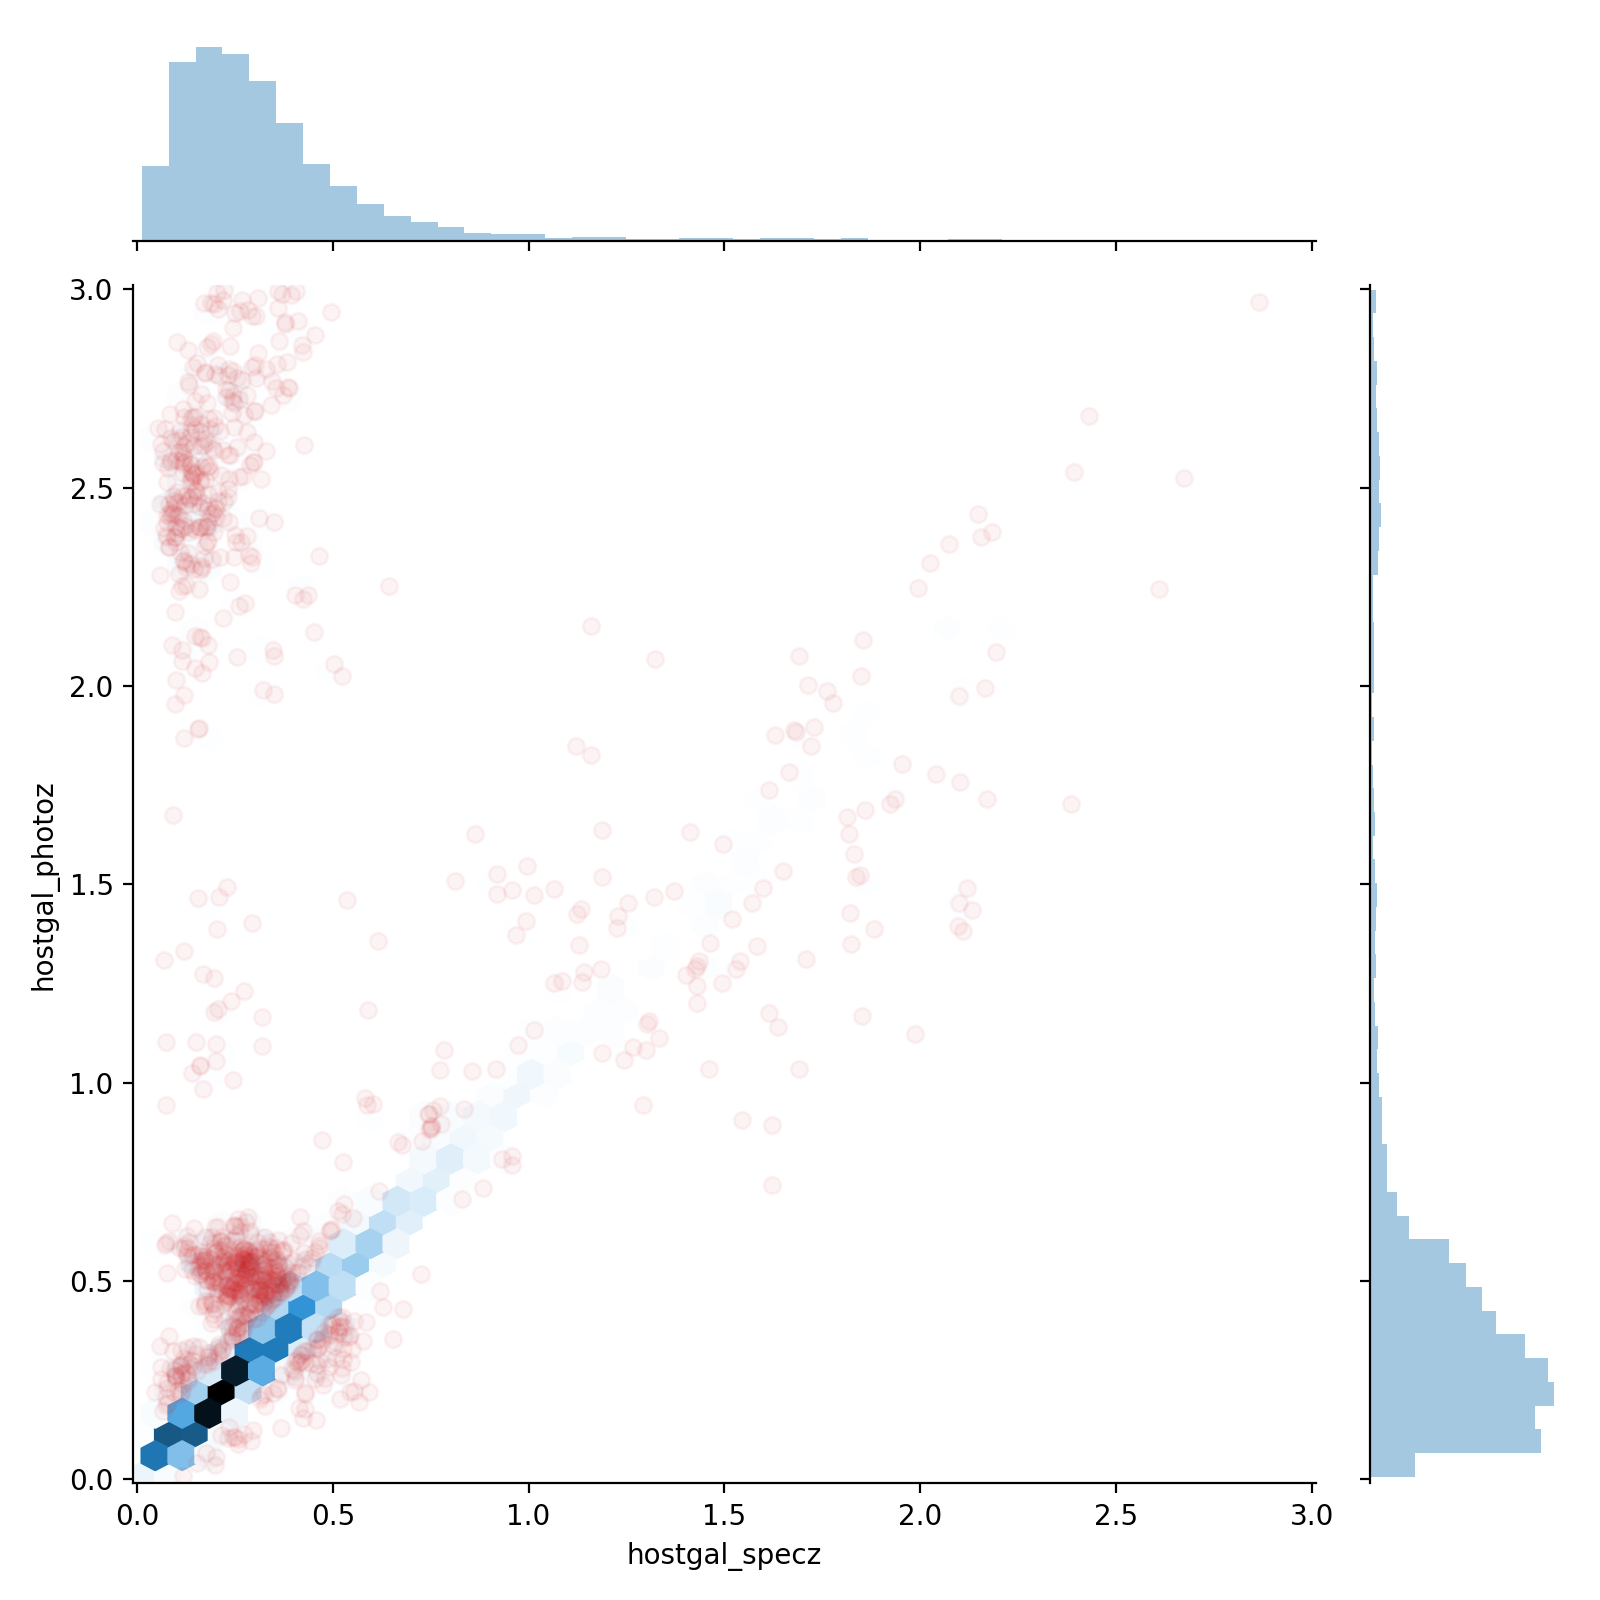

/Users/gnarayan/anaconda3/envs/plasticc/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


In [5]:
extragal = metadata['hostgal_specz'] != 0.
g = sns.jointplot(metadata['hostgal_specz'][extragal],\
              metadata['hostgal_photoz'][extragal], kind='hex',\
                  xlim=(-0.01, 3.01), ylim=(-0.01,3.01), height=8)

outliers = np.abs(metadata['hostgal_specz'] - metadata['hostgal_photoz']) > 0.1
fig = g.fig
fig.axes[0].scatter(metadata['hostgal_specz'][outliers],\
                    metadata['hostgal_photoz'][outliers], color='C3', alpha=0.05)
fig.tight_layout()

There's many potential choices. 

For now we'll leave everything together.

<IPython.core.display.Javascript object>


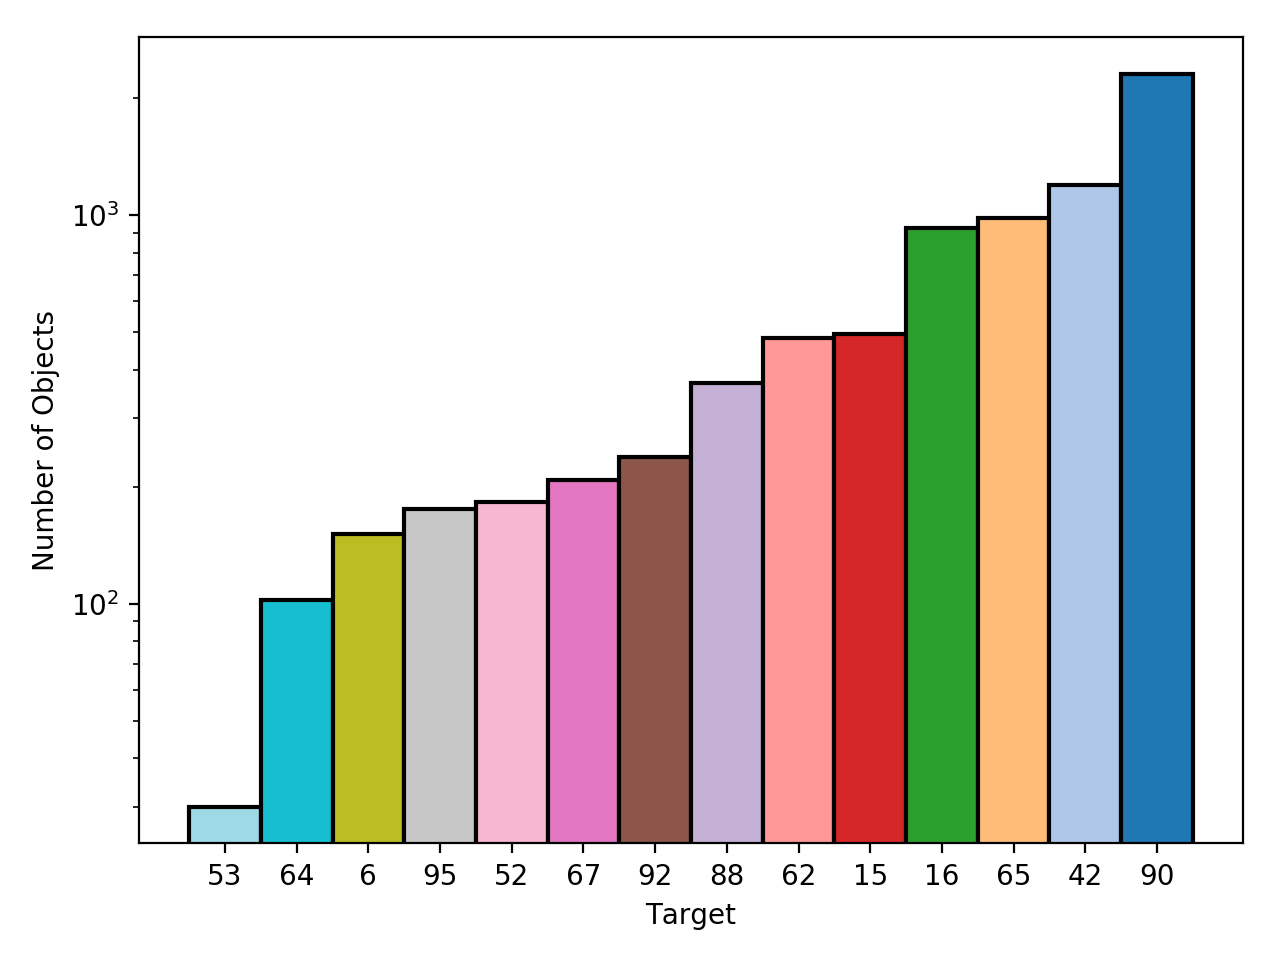

In [6]:
counts = Counter(metadata['target'])
labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
fig, ax = plt.subplots()

cmap = plt.cm.tab20
nlines = len(labels)
classcolor =  list(cmap(np.linspace(0,1,nlines)))[::-1]

# we'll create a mapping between class and color
classcolmap = dict(zip(labels, classcolor))

indexes = np.arange(nlines)
width = 1
ax.bar(indexes, values, width, edgecolor='k',\
       linewidth=1.5, tick_label=labels, log=True, color=classcolor)
ax.set_xlabel('Target')
ax.set_ylabel('Number of Objects')
fig.tight_layout()

You can see the class distribution in the training set is imbalanced. This reflects reality. The Universe doesn't produce all kinds of events at equal rates, and even if it did, some events are fainter than others, so we'd naturally find fewer of them than bright events.

Next, we'll read the light curve data. All the objects in the training set are in a single file:

In [7]:
lcfilename = f'{datadir}/plasticc_training_set.csv.gz'
lcdata = Table.read(lcfilename, format='csv')
lcdata

object_id,mjd,passband,flux,flux_err,detected_bool
int64,float64,int64,float64,float64,int64
615,59750.4229,2,-544.810303,3.622952,1
615,59750.4306,1,-816.434326,5.55337,1
615,59750.4383,3,-471.385529,3.801213,1
615,59750.445,4,-388.984985,11.395031,1
615,59752.407,2,-681.858887,4.041204,1
615,59752.4147,1,-1061.457031,6.472994,1
615,59752.4224,3,-524.95459,3.552751,1
615,59752.4334,4,-393.480225,3.599346,1
615,59752.4435,5,-355.88678,10.421921,1


Next, we'll make a `Timeseries` object using the `cesium` python package for each lightcurve.

In [8]:
tsdict = OrderedDict()
for i in tnrange(nobjects, desc='Building Timeseries'):
    row = metadata[i]
    thisid = row['object_id']
    target = row['target']
    
    meta = {'z':row['hostgal_photoz'],\
            'zerr':row['hostgal_photoz_err'],\
            'mwebv':row['mwebv']}
    
    ind = (lcdata['object_id'] == thisid)
    thislc = lcdata[ind]

    pbind = [(thislc['passband'] == pb) for pb in pbmap]
    t = [thislc['mjd'][mask].data for mask in pbind ]
    m = [thislc['flux'][mask].data for mask in pbind ]
    e = [thislc['flux_err'][mask].data for mask in pbind ]

    tsdict[thisid] = TimeSeries(t=t, m=m, e=e,\
                        label=target, name=thisid, meta_features=meta,\
                        channel_names=pbnames )
    
del lcdata

The list of features available with packages like `cesium` is <a href="http://cesium-ml.org/docs/feature_table.html">huge</a>. We'll only compute a subset now.

In [9]:
features_to_use = ["amplitude",
                   "percent_beyond_1_std",
                   "maximum",
                   "max_slope",
                   "median",
                   "median_absolute_deviation",
                   "percent_close_to_median",
                   "minimum",
                   "skew",
                   "std",
                   "weighted_average"]

In [10]:
# we'll turn off warnings for a bit, because numpy can be whiny. 
import warnings
warnings.simplefilter('ignore')

We'll start computing the features. This takes a while, so it's good to do this only the once, and save state. 

In principle you can avoid loading the data even if you run this again, but it's always a good idea to have access to your raw data while doing exploratory data analysis.

If you have access to a multiprocessing capabilities, it is usually a good idea to divide the feature computation task up. Particularly when you are dealing with the test set with about 3.5 million objects... 

We'll use whatever cores you have on your machine.

In [11]:
def worker(tsobj):
    global features_to_use
    thisfeats = featurize.featurize_single_ts(tsobj,\
    features_to_use=features_to_use,
    raise_exceptions=False)
    return thisfeats

In [12]:
featurefile = f'{datadir}/plasticc_featuretable.npz'
if os.path.exists(featurefile):
    featuretable, _ = featurize.load_featureset(featurefile)
else:
    features_list = []
    with tqdm_notebook(total=nobjects, desc="Computing Features") as pbar:
        with schwimmbad.MultiPool() as pool:  
            results = pool.imap(worker, list(tsdict.values()))
            for res in results:
                features_list.append(res)
                pbar.update()
            
    featuretable = featurize.assemble_featureset(features_list=features_list,\
                              time_series=tsdict.values())
    featurize.save_featureset(fset=featuretable, path=featurefile)

The computed feature table has descriptive statistics for each object - a low-dimensional encoding of the information in the light curves. `cesium` assembles it as a `MultiIndex` which does not make `sklearn` happy, so we'll make a simpler table out of it.

In [13]:
old_names = featuretable.columns.values
new_names = ['{}_{}'.format(x, pbmap.get(y,'meta')) for x,y in old_names]
cols = [featuretable[col] for col in old_names]
allfeats = Table(cols, names=new_names)
del featuretable

We'll split the training set into two - one for training in this demo and the other for testing.

We'll do this preserving class balance in the full training set, but remember the training set might not be representative. The class balance in the training set reflects whatever we've followed up spectroscopically prior to LSST science operations starting.

In [14]:
splitter = StratifiedShuffleSplit(n_splits=1, test_size=0.3, random_state=42)
splits = list(splitter.split(allfeats, metadata['target']))[0]
train_ind, test_ind = splits

Since there's multiple passbands in the data, and the passbands are all sampling the same underlying astrophysical event, it's reasonable to expect that the features we've computed to be correlated. 

To prevent overfitting, it's a probably a good idea to reduce the dimensionality of the dataset. We'll look at this correlation structure.

<IPython.core.display.Javascript object>


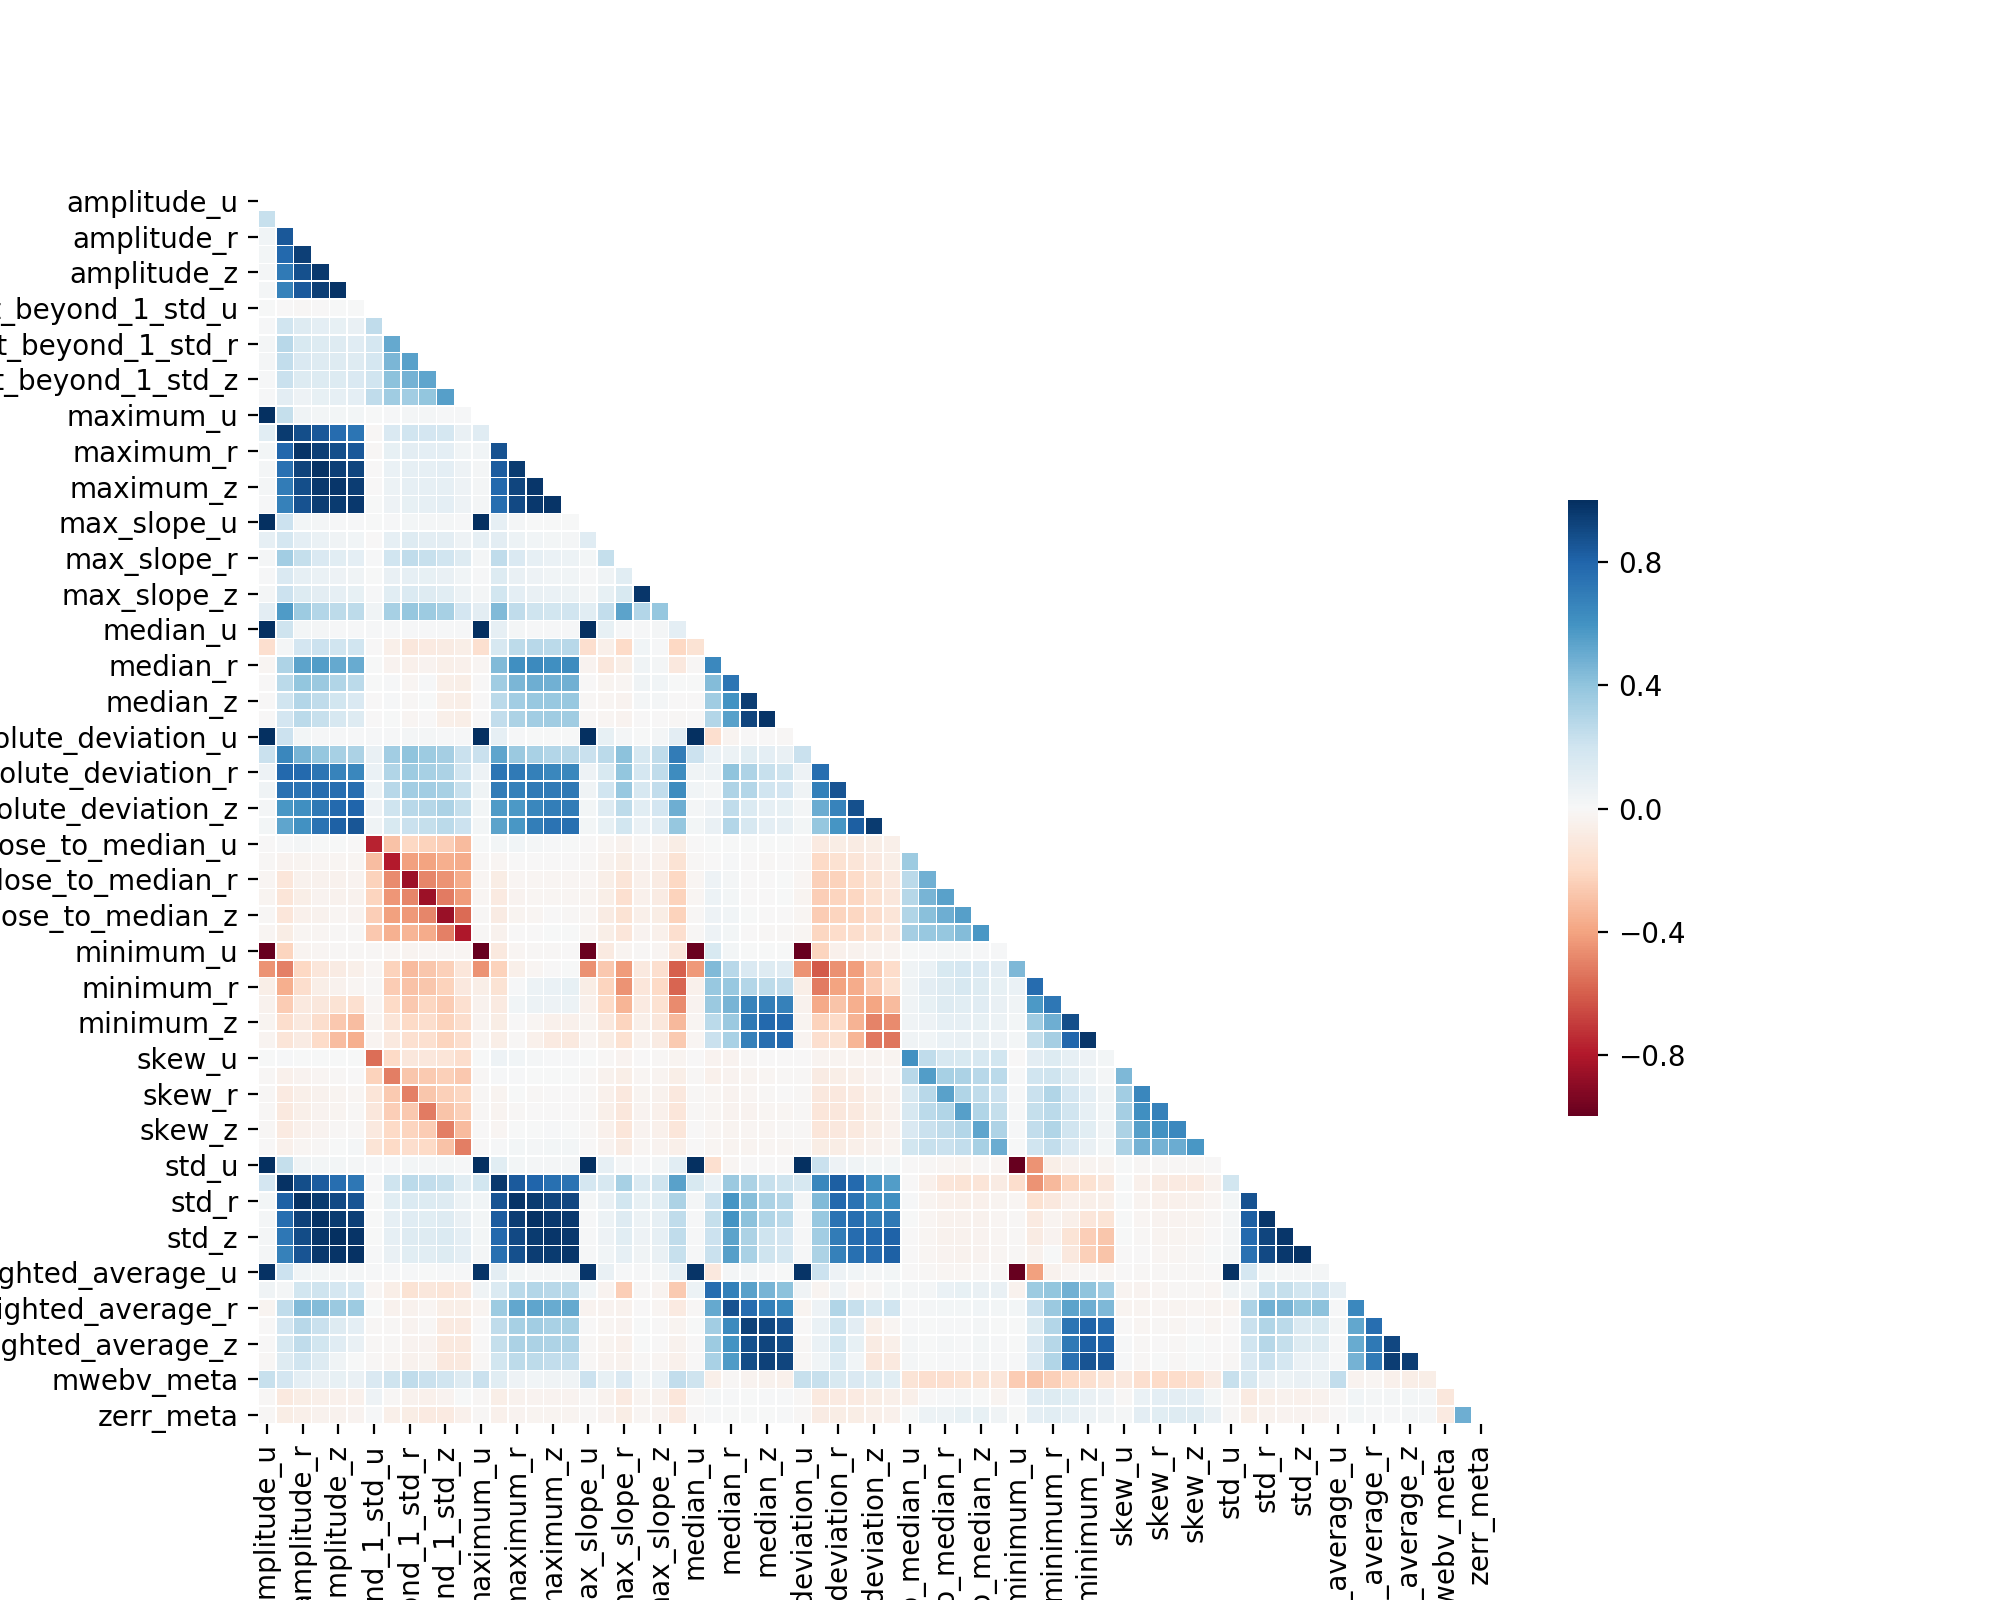

In [15]:
corr = allfeats.to_pandas().corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
fig, ax = plt.subplots(figsize=(10, 8))

# Draw the heatmap with the mask and correct aspect ratio
corr_plot = sns.heatmap(corr, mask=mask, cmap='RdBu', center=0,
                square=True, linewidths=.2, cbar_kws={"shrink": .5})

You can see some of the bands are strongly correlated with each other, so lets try to reduce the dimensionality of the dataset looking for a two effective passbands.

In [16]:
Xtrain = np.array(allfeats[train_ind].as_array().tolist())
Ytrain = np.array(metadata['target'][train_ind].tolist())

Xtest  = np.array(allfeats[test_ind].as_array().tolist())
Ytest  = np.array(metadata['target'][test_ind].tolist())

In [17]:
ncols = len(new_names)
npca  = (ncols  - 3)//len(pbnames)  + 3

In [18]:
pca = PCA(n_components=npca, whiten=True, svd_solver="full", random_state=42)
Xtrain_pca = pca.fit_transform(Xtrain)
Xtest_pca = pca.transform(Xtest)

<IPython.core.display.Javascript object>


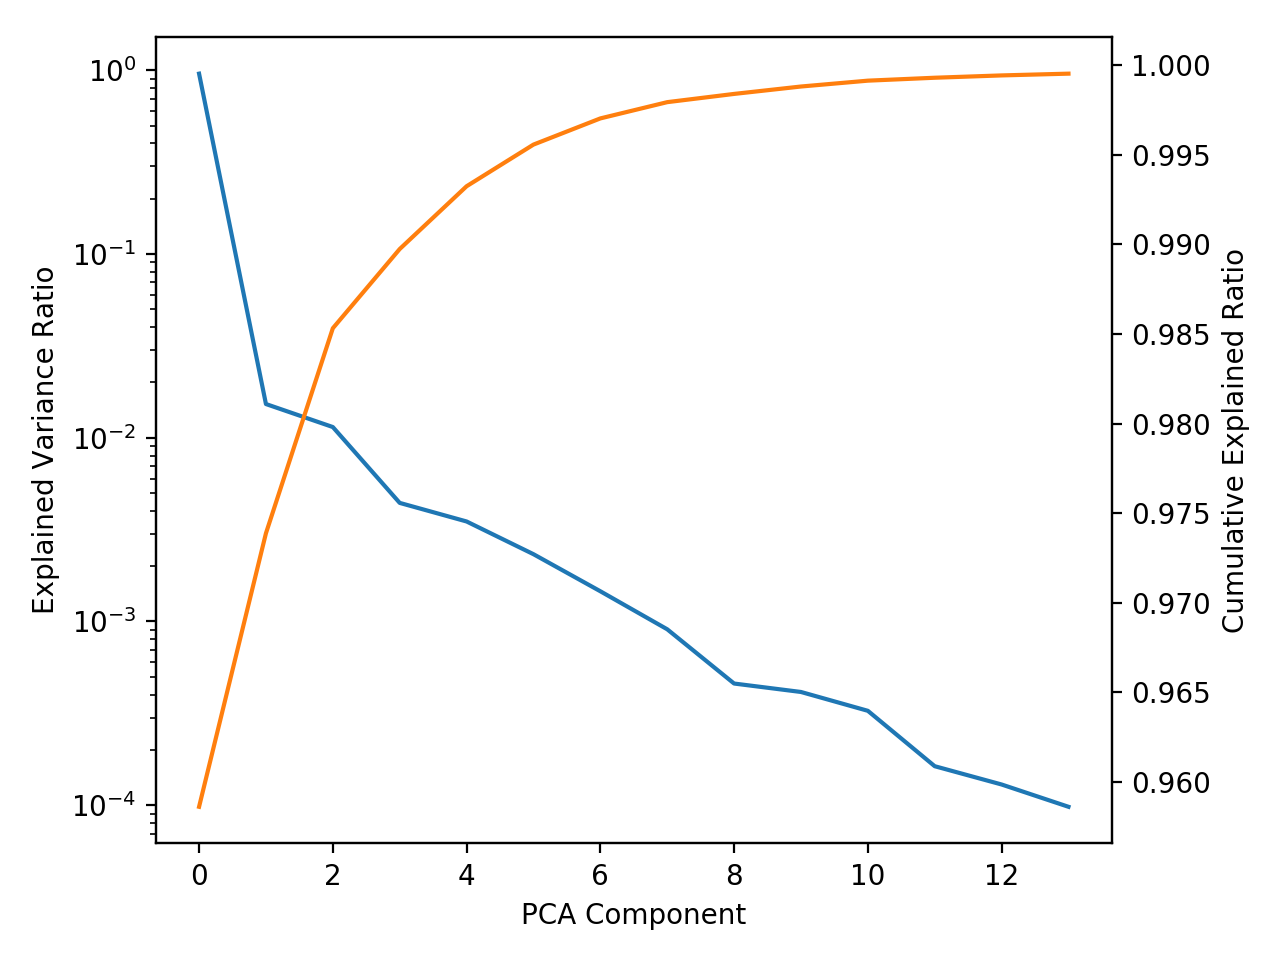

In [19]:
fig, ax = plt.subplots()
ax.plot(np.arange(npca), pca.explained_variance_ratio_, color='C0')
ax2 = ax.twinx()
ax2.plot(np.arange(npca), np.cumsum(pca.explained_variance_ratio_), color='C1')
ax.set_yscale('log')
ax.set_xlabel('PCA Component')
ax.set_ylabel('Explained Variance Ratio')
ax2.set_ylabel('Cumulative Explained Ratio')
fig.tight_layout()

Looks like a few features seem to hold all the weight! You might think to yourself that this is trivial! Lets build a simple classifier - we'll use a random forest here, but you can switch this out for whatever you like.

In [20]:
clf = RandomForestClassifier(n_estimators=200, criterion='gini',\
                       oob_score=True, n_jobs=-1, random_state=42,\
                      verbose=1, class_weight='balanced', max_features='sqrt')

Now let's apply the classifier to the data:

In [21]:
clf.fit(Xtrain_pca, Ytrain)
Ypred = clf.predict(Xtest_pca)

[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    0.3s
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:    1.2s
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:    1.3s finished
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 192 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 200 out of 200 | elapsed:    0.1s finished


And see just how well it worked by constructing a confusion matrix.

In [22]:
cm = confusion_matrix(Ytest, Ypred, labels=labels)
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
annot = np.around(cm, 2)

Which we can plot up...

<IPython.core.display.Javascript object>


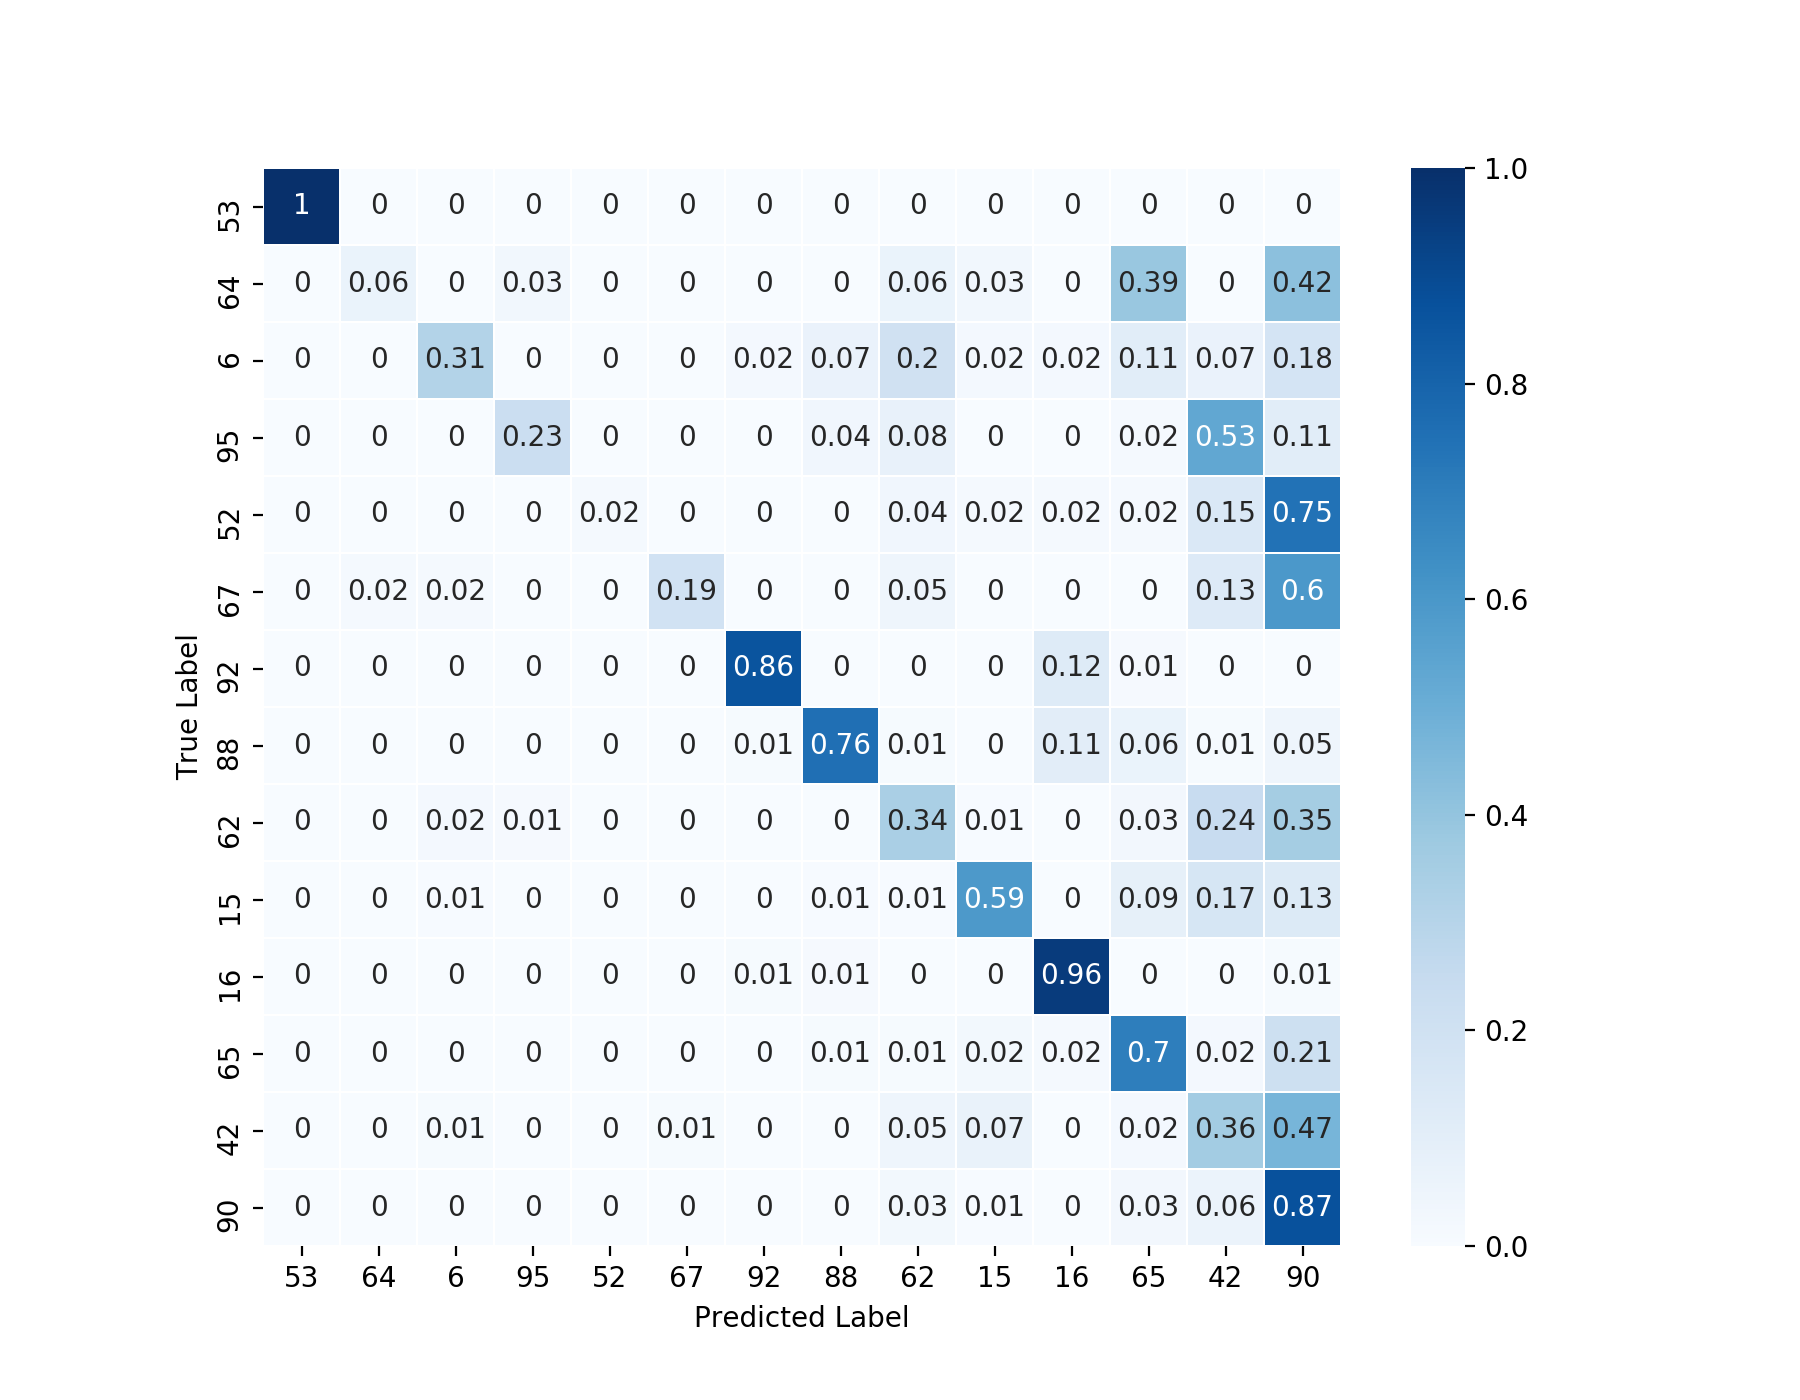

In [23]:
fig, ax = plt.subplots(figsize=(9,7))
sns.heatmap(cm, xticklabels=labels, yticklabels=labels, cmap='Blues', annot=annot, lw=0.5)
ax.set_xlabel('Predicted Label')
ax.set_ylabel('True Label')
ax.set_aspect('equal')

Ooer... Some classes seem to be easy to pick out. Others are being confused very badly. This reflects what happens in reality to astronomers. Some classes are easier to distinguish than others. 

You can also see the performance (or lack thereof) on the test data. 

Now this classifier is not the best we can do (by far), and it should be trivial for you to beat, but the fact is we can definitely use your expertise on this problem. There's many methods you can use to tackle this problem, and how you approach different aspects is going to be interesting to us regardless of how you do on the Kaggle leader board.

From data augmentation to feature engineering to re-balancing classes to outlier identification and hierarchical multi-class probabilistic classification, there's much we can learn from this.

We'll leave you with a few resources and references that might be useful to tackle this challenge:

# Resources

|Reference   | Light Curve fit  | Dimensionality <br> Reduction  | Classification <br> algorithm  | Use redshift  | Code available | 
|---|---|---|---|---|---|
|[Poznanski *et al*, 2006](https://arxiv.org/pdf/astro-ph/0610129.pdf)| --- | --- | Template fit | Yes | [pSNiD II](https://www.sas.upenn.edu/~gladney/html-physics/psnid/psnidII/)|
|[Newling *et al*, 2010](https://arxiv.org/pdf/1010.1005.pdf)   | parametric | parameters from fit  | Kernel Density Estimation <br> Boosting  | Yes  |  |
|[Richards *et al*, 2011](https://arxiv.org/pdf/1103.6034.pdf)   | spline  | diffusion maps  | Random Forest  | Yes  | |
|[Karpenka *et al*, 2012](https://arxiv.org/pdf/1208.1264.pdf)   |parametric | parameters from fit  | Neural Network  | No  | |
|[Ishida & de Souza, 2013](https://arxiv.org/pdf/1201.6676.pdf)| spline | kernel PCA | Nearest Neighbor | No |[github](https://github.com/emilleishida/snclass) |
|[Mislis *et al*, 2015](https://arxiv.org/abs/1511.03456) | --- | descriptive statistics | Random Forest | No | No | 
|[Varughese *et al*, 2015](https://arxiv.org/pdf/1504.00015.pdf)| spline | Wavelets | Nearest Neighbor <br> Support Vector Machine | No| |
|[Hernitschek *et al*, 2016](http://iopscience.iop.org/article/10.3847/0004-637X/817/1/73/meta)| $\chi^{2}$ | --- | Random Forest | No | No | 
|[Lochner *et al*, 2016](https://arxiv.org/pdf/1603.00882.pdf)|parametric <br> Gaussian Process | Wavelets<br> PCA <br> Model Fit | Naive Bayes<br> Nearest Neighbor <br> Support Vector Machine <br> Boosted Decision Trees |No|  |
|[Moller *et al*, 2016](https://arxiv.org/pdf/1608.05423.pdf) | parametric | parameters from fit| Boosted Decision Trees  <br> Random Forest | Yes | 
|[Charnok and Moss, 2017](https://arxiv.org/pdf/1606.07442.pdf)| --- | --- | Recurrent Neural Network | No|[github](https://github.com/adammoss/supernovae) |
|[Mahabal *et al*, 2017](https://arxiv.org/abs/1709.06257)| rate of change | ---| Neural Network | No |
|[Narayan *et al*, 2018](https://arxiv.org/abs/1801.07323) | parametric <br> Gaussian Process <br> | Wavelets<br> PCA <br> | Random Forest | No | No |
|[Revsbech *et al*, 2018](https://arxiv.org/pdf/1706.03811.pdf)|Gaussian Process|Diffusion Maps| Random Forest |Yes| [github](https://github.com/rtrotta/STACCATO)|
| [Dai *et al*, 2018](https://arxiv.org/pdf/1701.05689.pdf)|parametric|parameters from fit| Random Forest| No||

We're not suggesting reading all of these papers in detail and the references therein, but they will give you an overview of the sort of techniques astronomers have tried in the past, and will likely employ in this challenge.


#### Useful Packages for Astrophysics - particularly feature extraction

- [astropy](http://www.astropy.org/)
- [astroML](http://www.astroml.org/)
- [cesium](https://github.com/cesium-ml/cesium)
- [celerite](https://celerite.readthedocs.io/en/stable/)
- [FATS](https://github.com/isadoranun/FATS)
- [feets](https://github.com/carpyncho/feets)
- [gatspy](https://www.astroml.org/gatspy/)
- [sncosmo](http://sncosmo.github.io/)
- [tsfresh](https://tsfresh.readthedocs.io/en/latest/)
- [vartools](https://www.astro.princeton.edu/~jhartman/vartools.html)

All of these packages were developed for astrophysics and in particular light curve processing. Celerite is a general 1-D Gaussian Process package but the particular class of kernels it offers is suitable for astrophysics and allows it to be much faster than many other packages.

#### External Data Sources

If you are determined to try and augment the training set, or to learn more about the astrophysical sources in the data before building your data, then these resources might be useful to you. Note that you build in what biases are present in the training set into your classifier.

- [AAVSO](https://www.aavso.org/research-portal)
- [Open Astronomy Catalogs](https://astrocats.space/)
- [OGLE Collection of Variable Stars](http://ogledb.astrouw.edu.pl/~ogle/OCVS/)
- [SDSS DR12 Variables and Transients](https://www.sdss.org/dr12/algorithms/ancillary/boss/transient82/)

Remember that LSST may discover objects that are predicted but have never been seen yet. We can't give you examples of things that haven't been seen of course.

***

Again, find us on the Kaggle forums if you have questions we can answer.

Good luck!